In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from typing import Tuple
from scipy.optimize import minimize

In [42]:
RHO=997 #kg/m^3
G = 9.8 #m/s^2 #pho* g* h [kg/m/s^2 = N/m^2]
P_ATM = 101325 #Pa

rng = np.random.default_rng()

In [43]:
#水深からその場所での圧力推定値を出力する
def z_to_Pa(z:float, v=0.5):
  return (RHO*G*z+0.5*RHO*v**2)+P_ATM # N/m^2

In [44]:
#set initial value
time_devided = 65 #6.5s
p1 = z_to_Pa(0.5) #set the p1   ... t= 0 y =z_to_Pa(0.5)
amplitude = z_to_Pa(0.2)-z_to_Pa(0.0)
interval_T = 5 # 5s
time_range = 50 #5s
print(amplitude)

1954.1199999999953


In [46]:
def sine_func(params, t:float, interval:float=5, amplitude_p:float=25):
  #y = Asin(2pi * t/T)+p1+biasP  T:interval
  biasP = params[0]
  return p1+amplitude_p*np.sin(2*np.pi*t/interval)+biasP

def create_target_df(params, t:pd.Series, interval, amplitude_p) -> pd.DataFrame:
  time_array = t.to_numpy()
  data = {"time": t, "pressure": [sine_func(params, t, interval, amplitude_p) for t in time_array]}
  return pd.DataFrame(data)

In [47]:
def normalize(df_result: pd.DataFrame) -> pd.DataFrame:
    if df_result.shape[1] != 9:
        raise ValueError(f"Input has {df_result.shape[1]} columns; should be 9")
    df=df_result.set_axis(
        [
            "time",
            "acc_x",
            "acc_y",
            "acc_z",
            "pitch",
            "roll",
            "yaw",
            "pressure",
            "flag",
        ],
        axis='columns'
    )
    return df

In [49]:
def printgraph(df_result:pd.DataFrame):
  df = normalize(df_result)
  df_trunc = df[df["flag"] >= 1].head(time_range).reset_index(drop=True)
  df_target = create_target_df([0], df_trunc["time"], interval_T, amplitude)
  fig1, ax = plt.subplots()
  ax.plot(df_trunc["time"], df_trunc["pressure"], c = 'red', label = "input_data")
  ax.plot(df_target["time"], df_target["pressure"], c = 'green', label = "target_data")
  ax.set_xlabel("time(10^(-1) s)")
  ax.set_ylabel("Pressure(Pa)")
  ax.legend()
  plt.show

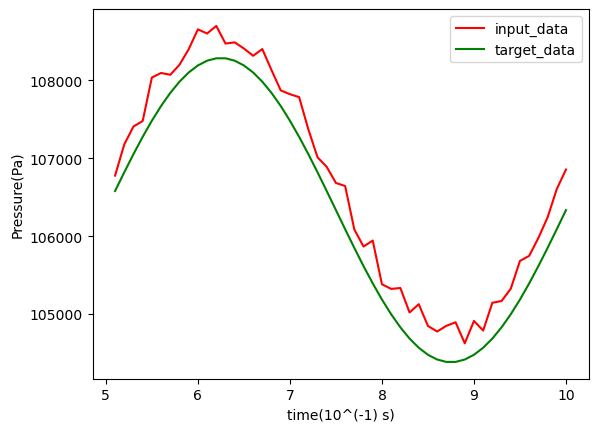

In [50]:
printgraph(pd.read_csv("input_demo_data.csv"))

In [51]:
def culc_score_pressure(params, df_result: pd.DataFrame): #input df_result is raw data(no trunctuated, no normalized)
    df = normalize(df_result)
    df_trunc = df[df["flag"] >= 1].head(time_range).reset_index(drop=True) #与えられたデータから5s間を抽出
    df_target = create_target_df(params, df_trunc["time"], interval_T, amplitude)#同じ時間幅でtargetデータをセットbias=0
    series_square = (df_trunc["pressure"]-df_target["pressure"])**2
    score = np.mean(series_square.to_numpy())
    return score

In [52]:
#試しにbias入れずにscore出してみる
df_test = pd.read_csv("input_demo_data.csv")
print(df_test.head())
print(f"pressure loss = {culc_score_pressure([0],df_test): .3f}")


   date  a_x  a_y  a_z  angx  angy  angz       pressure  flag
0   0.0    0    0    0     0     0     0  106871.485655     0
1   0.1    0    0    0     0     0     0  107015.710445     0
2   0.2    0    0    0     0     0     0  107312.327040     0
3   0.3    0    0    0     0     0     0  107485.872259     0
4   0.4    0    0    0     0     0     0  107739.446671     0
pressure loss =  138917.305


In [53]:
#pressureのスコアの計算, bias含めてのフィッティング
def score_pressure_withBias(df_result: pd.DataFrame) -> Tuple[float,float]:
    initial_guess = [0.0]
    result = minimize(culc_score_pressure, initial_guess, args = (df_result))
    scoreWithBias = result.fun
    bias = result.x[0]
    return scoreWithBias, bias

In [54]:
print(score_pressure_withBias(pd.read_csv("input_demo_data.csv")))

(13464.70124228124, 354.1928874986037)


In [61]:
def print_challenge2_result(df_result: pd.DataFrame, dir_out='./output/', filename=datetime.datetime.now().strftime("%Y-%m-%d %H%M%S")):
  scoreWithoutBias = culc_score_pressure([0], df_result)
  scoreWithBias, bias = score_pressure_withBias(df_result)
  df = normalize(df_result)
  df_trunc = df[df["flag"] >= 1].head(time_range).reset_index(drop=True)
  df_target = create_target_df([0], df_trunc["time"], 5, z_to_Pa(0.2)-z_to_Pa(0))
  df_target_bias = create_target_df([bias], df_trunc["time"], interval_T, amplitude)
  fig1, axs = plt.subplots(2,1, figsize = (9,16))
  axs[0].set_title(f"score without bias: {scoreWithoutBias: .3f}")
  axs[0].plot(df_trunc["time"], df_trunc["pressure"], c = 'red', label = "input_data")
  axs[0].plot(df_target["time"], df_target["pressure"], c = 'green', label = "target_data")
  axs[0].set_xlabel("time(10^(-1) s)")
  axs[0].set_ylabel("Pressure(Pa)")
  axs[0].legend()

  axs[1].set_title(f"score with bias: {scoreWithBias: .3f}, bias {bias: .3f}")
  axs[1].plot(df_trunc["time"], df_trunc["pressure"], c = 'red', label = "input_data")
  axs[1].plot(df_target_bias["time"], df_target_bias["pressure"], c = 'green', label = "target_data fixed")
  axs[1].set_xlabel("time(10^(-1) s)")
  axs[1].set_ylabel("Pressure(Pa)")
  axs[1].legend()
  
  # Output
  path_out = Path(dir_out)
  if not path_out.exists():
    path_out.mkdir(parents=True, exist_ok=True)
  plt.savefig(path_out.joinpath(f"{filename}.png"), bbox_inches="tight")
  plt.savefig(path_out.joinpath(f"{filename}.pdf"), bbox_inches="tight")

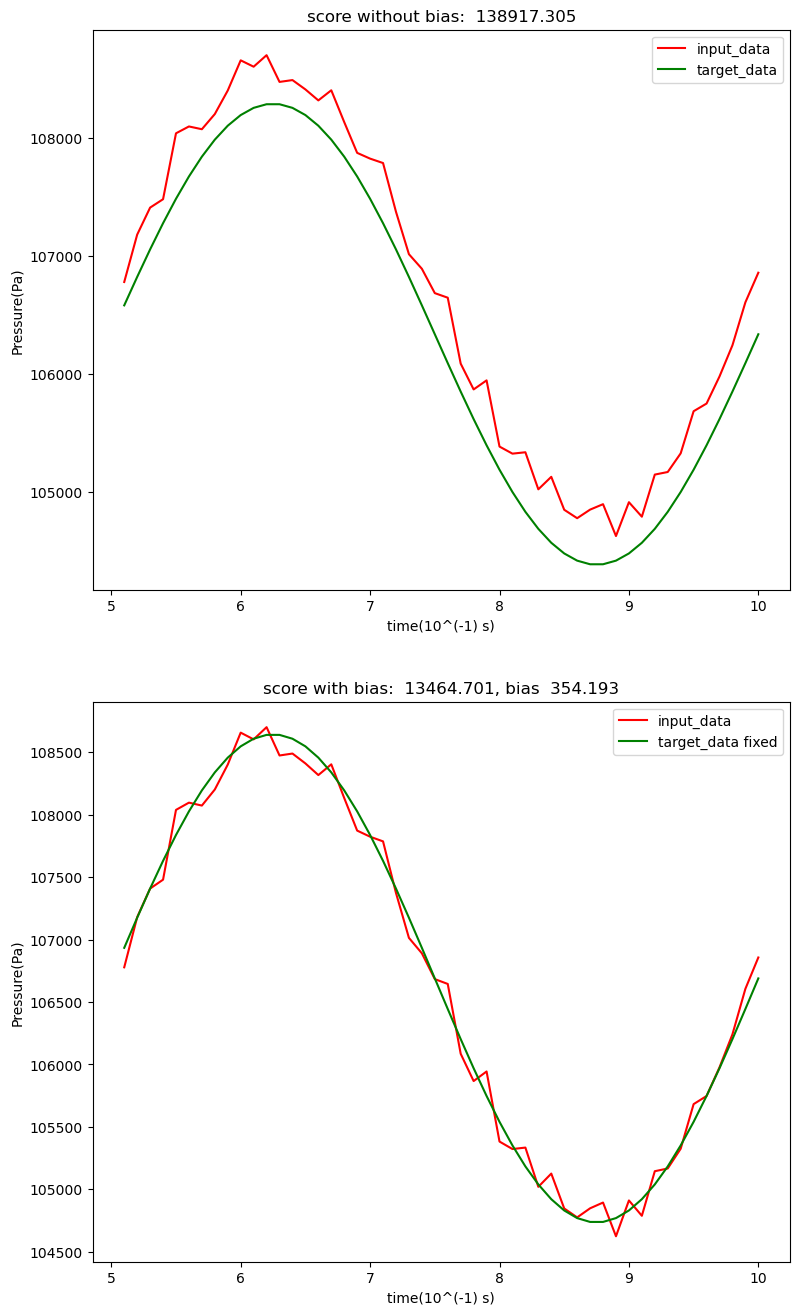

In [62]:
print_challenge2_result(pd.read_csv("input_demo_data.csv"))